# Tutorial: Numpyro
## Fitting a Draco-like galaxy with a plummer profile embedded in a dark matter halo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"
import numpyro

numpyro.enable_x64()
import jax
from jax._src.config import config

config.update("jax_enable_x64", True)
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt

I'll be assuming that not all data sets will have consistent naming.
He're i'll show an example of how to write a simple subclass that will then allow you to use the builtin methods in DynamicAll

In [3]:
import dynamicAll
from dynamicAll import data, models

In [4]:
data_path = "/Users/juan/Desktop/dracoish.txt"

In [5]:
input_data = pd.read_csv(data_path, header=0).dropna()  # drop all nan values

In [6]:
input_data

,RA,DEC,MAG_G,MAG_I,ANGSEP,RPROJ,SNR,VTRUE,VSTAT,VSYS,VMEAS,VMEASERR,VSYSERR,VERR
0,53.88518,-54.02280,23.32272,23.12567,0.07122,0.09447,5.41586,44.11046,-0.68338,0.70942,44.13650,4.16485,2.0,4.62017
1,54.06523,-53.93597,17.65393,16.74092,0.07465,0.09902,363.11669,72.04525,0.03049,3.05323,75.12897,0.02679,2.0,2.00018
2,54.06599,-53.77255,19.90599,19.92407,0.23075,0.30608,68.42616,56.36690,-0.17761,-0.02299,56.16629,0.19849,2.0,2.00983
3,54.02349,-53.97031,23.25164,23.05304,0.03274,0.04343,5.71572,65.04756,2.09910,-5.76456,61.38210,3.90405,2.0,4.38652
4,54.02006,-53.96624,21.72529,21.27512,0.03576,0.04743,25.99445,59.43007,0.01197,-0.68023,58.76180,0.63408,2.0,2.09811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,53.87506,-53.98700,21.87238,21.42785,0.07459,0.09894,23.23569,48.53974,-0.14664,1.43758,49.83068,0.72546,2.0,2.12751
11048,54.02857,-54.20824,22.87137,22.61137,0.20891,0.27711,8.54196,69.48248,-2.54854,-3.29287,63.64107,2.41063,2.0,3.13228
11049,53.85962,-53.76057,22.81739,22.53252,0.25333,0.33603,9.07093,67.13552,-1.77017,-0.58418,64.78117,2.24294,2.0,3.00513
11050,54.15867,-53.91983,19.48593,18.89245,0.12306,0.16323,124.43928,64.93852,-0.18654,1.14014,65.89211,0.09684,2.0,2.00234


In [7]:
R = input_data["RPROJ"].values
vlos = input_data["VMEAS"].values
error = input_data["VERR"].values

In [8]:
error

array([4.62017, 2.00018, 2.00983, ..., 3.00513, 2.00234, 4.71151])

(array([  2.,   1.,   3.,   4.,   8.,  14.,  19.,  24.,  39.,  55.,  46.,
         68., 102., 119., 141., 171., 236., 291., 276., 329., 383., 410.,
        471., 457., 487., 501., 516., 551., 520., 494., 506., 513., 421.,
        387., 401., 330., 315., 274., 234., 238., 170., 124.,  84.,  80.,
         76.,  46.,  35.,  21.,  24.,   9.,  15.,   6.,   1.,   2.,   2.]),
 array([27.37826   , 28.55487164, 29.73148327, 30.90809491, 32.08470655,
        33.26131818, 34.43792982, 35.61454145, 36.79115309, 37.96776473,
        39.14437636, 40.320988  , 41.49759964, 42.67421127, 43.85082291,
        45.02743455, 46.20404618, 47.38065782, 48.55726945, 49.73388109,
        50.91049273, 52.08710436, 53.263716  , 54.44032764, 55.61693927,
        56.79355091, 57.97016255, 59.14677418, 60.32338582, 61.49999745,
        62.67660909, 63.85322073, 65.02983236, 66.206444  , 67.38305564,
        68.55966727, 69.73627891, 70.91289055, 72.08950218, 73.26611382,
        74.44272545, 75.61933709, 76.7959487

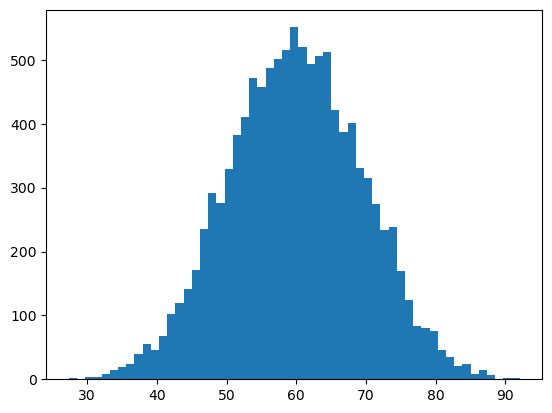

In [9]:
fig, ax = plt.subplots()
ax.hist(vlos, bins="auto")

## Define your custom Data set

In [10]:
class Dsphsim(dynamicAll.base.Data):
    def __init__(self, table):
        self.table = table
        self._R = table["RPROJ"].values
        self._vlos = table["VMEAS"].values
        self.d_vlos = table["VERR"].values

        super().__init__()

In [11]:
dataSet = Dsphsim(input_data)

/Users/juan/phd/projects/dynamicAll/src/dynamicAll/base.py:1671: UserWarning: The '_r' component is not defined.\nOnly projected moments may be available.
  warnings.warn(
/Users/juan/phd/projects/dynamicAll/src/dynamicAll/base.py:1676: UserWarning: 'pmr' and 'pmt' components are not defined.\nVelocity dispersion for these components will not be available.\n only 'los' moment will be available
  warnings.warn(


Don't worry about the warnings. it'll give out some sort of warning unless you put in 6D data.

In [12]:
print(dataSet._component_map.keys())

dict_keys(['los'])


In [13]:
dataSet._component_map

{'los': (array([0.09447, 0.09902, 0.30608, ..., 0.33603, 0.16323, 0.08424]),
  array([44.1365 , 75.12897, 56.16629, ..., 64.78117, 65.89211, 57.66495]),
  array([4.62017, 2.00018, 2.00983, ..., 3.00513, 2.00234, 4.71151]))}

In [14]:
# R_center,los_disp,dlos_disp,bin_edges = dataSet.dispersion_i('los',binfunc=np.histogram,bins='auto',clear_cache=True)
R_center, los_disp, dlos_disp, bin_edges = dataSet.dispersion_i(
    "los", clear_cache=True
)  # binfunc=np.histogram,bins='auto',clear_cache=True)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 976.68it/s, 1 steps of size 4.76e-01. acc. prob=0.93] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  global_sigmav      8.91      0.07      8.91      8.79      9.01    331.43      1.00
  mean_velocity     59.91      0.09     59.90     59.75     60.05    952.53      1.00

Number of divergences: 0


sample: 100%|██████████| 1500/1500 [00:02<00:00, 638.12it/s, 7 steps of size 6.69e-01. acc. prob=0.86] 



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 dispersion[0]     12.54      1.73     12.39      9.91     15.28   1957.13      1.00
 dispersion[1]      9.85      0.58      9.81      8.89     10.74   2601.76      1.00
 dispersion[2]      9.90      0.47      9.88      9.22     10.71   2603.38      1.00
 dispersion[3]     10.45      0.33     10.43      9.95     11.02   2965.87      1.00
 dispersion[4]      9.33      0.14      9.33      9.10      9.57   2309.39      1.00
 dispersion[5]      8.75      0.14      8.75      8.53      8.98   2145.39      1.00
 dispersion[6]      8.37      0.19      8.37      8.06      8.68   2252.81      1.00
 dispersion[7]      9.00      0.30      9.00      8.54      9.53   1945.37      1.00
 dispersion[8]      8.45      0.22      8.45      8.07      8.80   2366.23      1.00
 dispersion[9]      8.60      0.34      8.58      7.98      9.08   2292.02      1.00
dispersion[10]      8.54      0.29      8.53      8.12      9.05

In [15]:
dataSet._component_map["los"]

(array([0.09447, 0.09902, 0.30608, ..., 0.33603, 0.16323, 0.08424]),
 array([44.1365 , 75.12897, 56.16629, ..., 64.78117, 65.89211, 57.66495]),
 array([4.62017, 2.00018, 2.00983, ..., 3.00513, 2.00234, 4.71151]))

[None,
 Text(0.5, 0, 'R'),
 Text(0, 0.5, '$\\sigma_{\\rm los}(R) $'),
 (0.0, 20.0)]

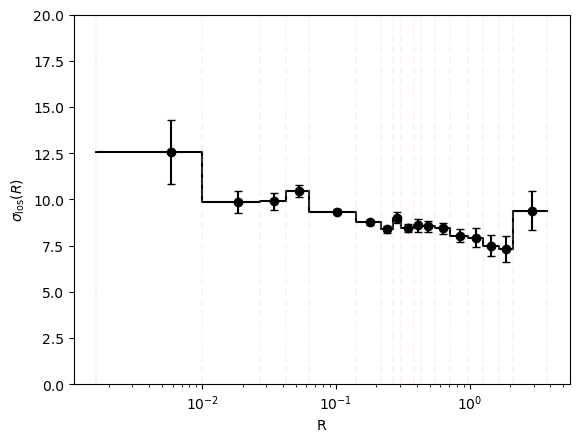

In [16]:
import numpy as np

fig, ax = plt.subplots()

# First plot error bars
ax.errorbar(
    R_center, los_disp, yerr=dlos_disp, fmt="o", color="k", capsize=3, elinewidth=1.5
)

# plot step function -- Note ax.step is a bit misleading so we'll do it a bit more carefully.

step_edges = np.repeat(bin_edges, 2)[1:-1]

ax.step(
    step_edges,
    np.repeat(los_disp, 2),
    where="post",
    label="Binned Data",
    linewidth=1.5,
    color="k",
)

for i in bin_edges:
    ax.axvline(i, ls="--", alpha=0.2, color="pink")

ax.set(
    xscale="log",
    xlabel="R",
    ylabel=r"$\sigma_{\rm los}(R) $",
    ylim=(0, 20),
)

[1.08404907e+04 1.95615534e-01] [[2.32480862e+04 2.24652870e-01]
 [2.24652870e-01 2.28778919e-06]]


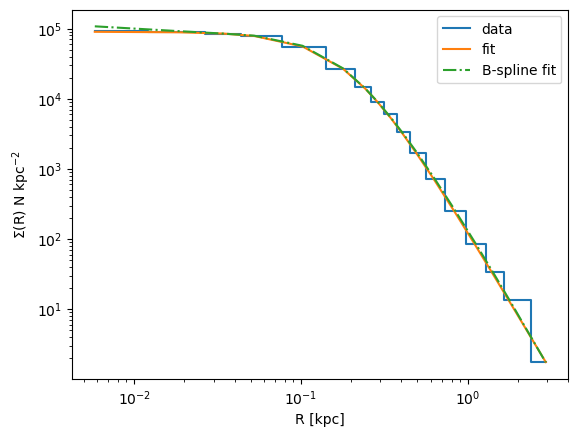

In [17]:
# Define function you want to fit the data to
func = models.Plummer._projection
# plot curve_fit of curve
fig, ax, popt, pcov = dataSet.fit_projection(func, p0=[1e3, 0.25])

# plot B-spline fit
ax.plot(
    R_center, dataSet.bspline_projected(R_center), linestyle="-.", label="B-spline fit"
)
# # plot truth
# ax.plot(R_center,models.Plummer.projection(R_center,1e3,0.25),
#     label='truth',
#     linestyle ='--')
ax.legend()
print(popt, pcov)

In [18]:
from dynamicAll import fit

In [19]:
from numpyro import distributions as dist

priors = fit.Priors()
tracer_priors = {
    "tracer_M": dist.Normal(1e4, 100),  # update thats based on the fit above
    "tracer_a": dist.Normal(0.226, 0.01),
}

dm_priors = {
    "dm_gamma": dist.Uniform(-1.0, 2.0),
    "dm_rhos": dist.Uniform(5, 30),  # These are in logspace
    "dm_rs": dist.Uniform(-10, 10),  # These are in logspace
}

anisotropy_priors = {"beta_0": dist.Uniform(-1, 1)}


priors.add_from_dict(tracer_priors)
priors.add_from_dict(dm_priors)
priors.add_from_dict(anisotropy_priors)
# check priors
priors

Parameter: tracer_M, Distribution: Normal, Mean: 1.00e+04, StdDev: 1.00e+02
Parameter: tracer_a, Distribution: Normal, Mean: 2.26e-01, StdDev: 1.00e-02
Parameter: dm_gamma, Distribution: Uniform, Bounds: (-1.00e+00, 2.00e+00)
Parameter: dm_rhos, Distribution: Uniform, Bounds: (5.00e+00, 3.00e+01)
Parameter: dm_rs, Distribution: Uniform, Bounds: (-1.00e+01, 1.00e+01)
Parameter: beta_0, Distribution: Uniform, Bounds: (-1.00e+00, 1.00e+00)


In [20]:
system = fit.SphGalaxy(priors=priors)

No tracer model defined.
Using default Plummer model.

No DM model defined.
Using default gNFW model.

No anisotropy model defined.
using default BetaConstant model



In [21]:
import astropy.units as u

theta = (0.5 * u.deg).to(u.rad).value
d_dracoish = 50.0  # So I can compare to Chang et. al. 2020
rt_dracoish = 25.54  # kpc (r_200-ish for these scale density/radius values)

j_factor_params = {"theta": theta, "D": d_dracoish, "rt": rt_dracoish}

mcmc = system.fit_dSph(
    dataSet, num_samples=2000, jfactor=True, jfactor_params=j_factor_params
)

Parameter: tracer_M, Distribution: Normal, Mean: 1.00e+04, StdDev: 1.00e+02
Parameter: tracer_a, Distribution: Normal, Mean: 2.26e-01, StdDev: 1.00e-02
Parameter: dm_gamma, Distribution: Uniform, Bounds: (-1.00e+00, 2.00e+00)
Parameter: dm_rhos, Distribution: Uniform, Bounds: (5.00e+00, 3.00e+01)
Parameter: dm_rs, Distribution: Uniform, Bounds: (-1.00e+01, 1.00e+01)
Parameter: beta_0, Distribution: Uniform, Bounds: (-1.00e+00, 1.00e+00)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [22]:
import arviz

inf_data = arviz.from_numpyro(mcmc)
arviz.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-0.079,0.242,-0.564,0.268,0.012,0.010,516.0,388.0,1.00
dm_gamma,0.878,0.730,-0.571,1.924,0.029,0.024,449.0,275.0,1.00
dm_rhos,17.953,2.912,12.715,22.190,0.165,0.117,444.0,269.0,1.01
dm_rs,-0.422,1.189,-2.058,1.681,0.070,0.058,449.0,275.0,1.01
jfactor,19.369,0.683,18.811,20.959,0.038,0.027,477.0,281.0,1.00
tracer_M,9996.560,98.045,9809.679,10174.939,2.186,1.546,2011.0,1924.0,1.00
tracer_a,0.226,0.010,0.206,0.243,0.000,0.000,1610.0,1880.0,1.00


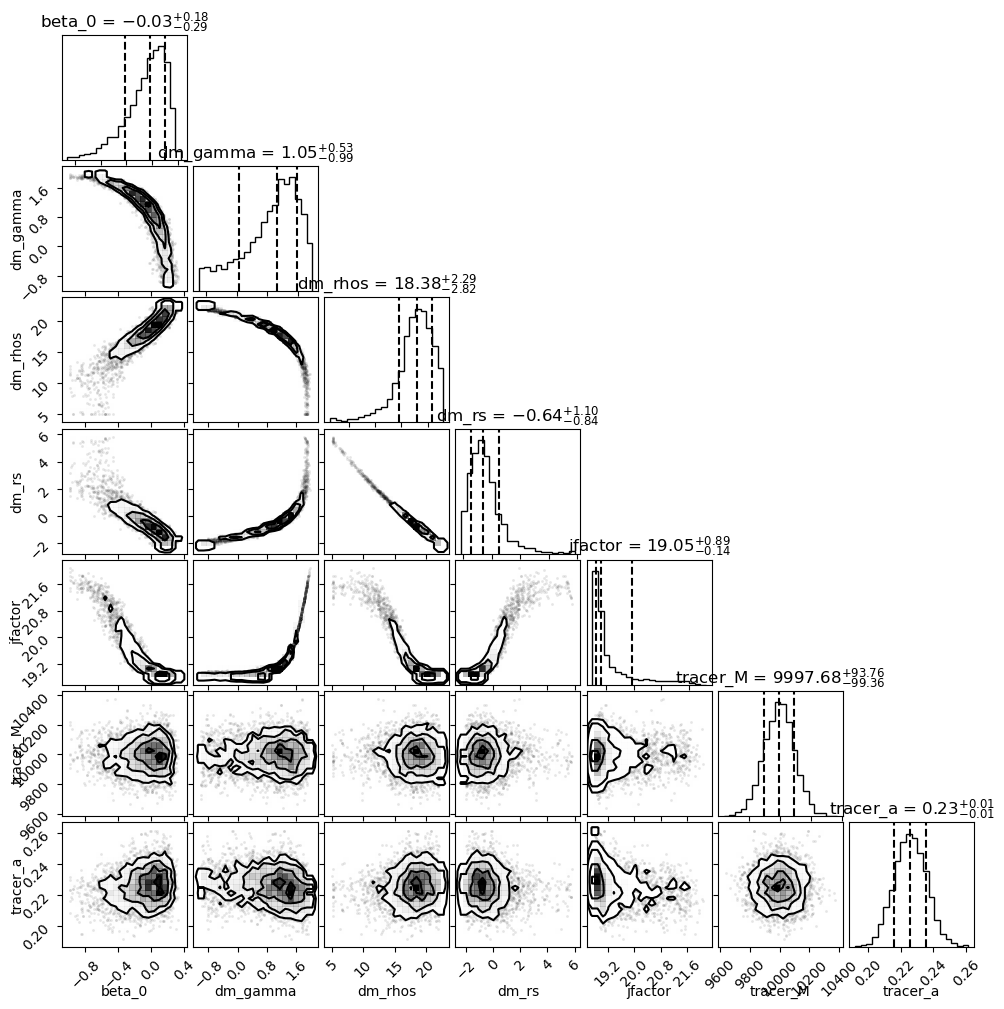

In [23]:
import corner

fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(10, 10))
corner.corner(inf_data, fig=fig, quantiles=[0.16, 0.5, 0.84], show_titles=True)
ax = ax.flatten()
# ax[12].set(
#     yscale='log',
#     ylim = (jnp.exp(5),jnp.exp(30))c
# );
# ax[31].set(
#     # yscale='log',
#     # ylim = (jnp.exp(5),jnp.exp(30))
#     xlim = (0,5)
# );